# Lecture 5 - Finite differences and an introduction to Devito

## Forward (and backward) modelling

In introducing the FWI workflow in lecture 3, it's clear that modelling the propagation of waves in the medium (we are imaging) is a fundamental part of the algorithm. For this modelling, a whole range of wave-equations (isotropic-acoustic, elastic, viscoelastic, anisotropic-viscoacoustic etc. etc.) and numerical techniques (Finite difference, finite (spectral) element) are available.

Which choices are 'better' depends on a huge number of factors:
- What problem are we solving?
- How good is our field/lab data and what information does it contain?
- How big is our computer/How much time/money do we have? i.e. What computational resources are available?
- What codes do we have?

For the purpose of todays lecture, we'll focus on solving the isotropic acoustic wave-equation via the finite difference method. To build our wave-propagator we'll utilize the domain specific language **Devito**.

## What is a domain specific language (DSL) and what is Devito?

From [Wikipedia](https://en.wikipedia.org/wiki/Domain-specific_language):

*A domain-specific language (DSL) is a computer language specialized to a particular application domain. This is in contrast to a general-purpose language (GPL), which is broadly applicable across domains. There are a wide variety of DSLs, ranging from widely used languages for common domains, such as HTML for web pages, down to languages used by only one or a few pieces of software, such as MUSH soft code. DSLs can be further subdivided by the kind of language, and include domain-specific markup languages, domain-specific modeling languages (more generally, specification languages), and domain-specific programming languages. Special-purpose computer languages have always existed in the computer age, but the term "domain-specific language" has become more popular due to the rise of domain-specific modeling. Simpler DSLs, particularly ones used by a single application, are sometimes informally called mini-languages.*

Devito for example, is a DSL designed for solving partial differential equations via the finite difference method (or more generally performing stencil based computations on structured grids). A few more bits of information re. Devito:
- Devito is an [open source](https://github.com/devitocodes/devito) developed in the Department of Earth Science and Engineering at Imperial College.
- It is in fact a DSL and **compiler**:
 - The DSL heavily subclasses (makes lots of use of) `SymPy` and the compiler *converts* the symbolic specification of the mathematics problem into optimized c-code.
- Devito can compile c-code suitable for use on Super-computers and GPUs out of the box.

Before talking about anything more, lets dive in and see Devito in action.

## Introduction to the Devito DSL (and finite differences)

For convenience, we import all Devito modules:

In [1]:
from devito import * # (Not a good idea in an actual project!)

### From equations to code in a few lines of Python

The main objective of this section is to demonstrate how Devito and its [SymPy](http://www.sympy.org/en/index.html)-powered symbolic API can be used to solve partial differential equations using the finite difference method with highly optimized stencils in a few lines of Python. We demonstrate how computational stencils can be derived directly from the equation in an automated fashion and how Devito can be used to generate and execute, at runtime, the desired numerical scheme in the form of optimized C code.

### Defining the physical domain

Before we can begin creating finite-difference (FD) stencils we will need to give Devito a few details regarding the computational domain within which we wish to solve our problem. For this purpose we create a `Grid` object that stores the physical `extent` (the size) of our domain and knows how many points we want to use in each dimension to discretise our data.

<img src="figures/grid.png" style="width: 220px;"/>

In [2]:
grid = Grid(shape=(5, 6), extent=(1., 1.))
grid

Grid[extent=(1.0, 1.0), shape=(5, 6), dimensions=(x, y)]

### Functions and data

To express our equation in symbolic form and discretise it using finite differences, Devito provides a set of `Function` types. A `Function` object:

1. Behaves like a `sympy.Function` symbol
2. Manages data associated with the symbol

To get more information on how to create and use a `Function` object, or any type provided by Devito, we can take a look at the documentation.

In [3]:
print(Function.__doc__)


    Tensor symbol representing a discrete function in symbolic equations.

    A Function carries multi-dimensional data and provides operations to create
    finite-differences approximations.

    A Function encapsulates space-varying data; for data that also varies in time,
    use TimeFunction instead.

    Parameters
    ----------
    name : str
        Name of the symbol.
    grid : Grid, optional
        Carries shape, dimensions, and dtype of the Function. When grid is not
        provided, shape and dimensions must be given. For MPI execution, a
        Grid is compulsory.
    space_order : int or 3-tuple of ints, optional
        Discretisation order for space derivatives. Defaults to 1. ``space_order`` also
        impacts the number of points available around a generic point of interest.  By
        default, ``space_order`` points are available on both sides of a generic point of
        interest, including those nearby the grid boundary. Sometimes, fewer points
        s

Ok, let's create a function $f(x, y)$ and look at the data Devito has associated with it. Please note that it is important to use explicit keywords, such as `name` or `grid` when creating `Function` objects.

In [4]:
f = Function(name='f', grid=grid)
f

f(x, y)

In [5]:
f.data

Data([[0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.],
      [0., 0., 0., 0., 0., 0.]], dtype=float32)

By default, Devito `Function` objects use the spatial dimensions `(x, y)` for 2D grids and `(x, y, z)` for 3D grids. To solve a PDE over several timesteps a time dimension is also required by our symbolic function. For this Devito provides an additional function type, the `TimeFunction`, which incorporates the correct dimension along with some other intricacies needed to create a time stepping scheme.

In [6]:
g = TimeFunction(name='g', grid=grid)
g

g(t, x, y)

Since the default time order of a `TimeFunction` is `1`, the shape of `f` is `(2, 5, 6)`, i.e. Devito has allocated two buffers to represent `g(t, x, y)` and `g(t + dt, x, y)`:

In [7]:
g.shape

(2, 5, 6)

### Derivatives of symbolic functions (and a detour into finite differences)

First, lets have a quick overview of Finite differences. Consider a function $f(x,t)$. Recall that the Taylor series of $f(x,t)$ in the spatial dimension takes the form

\begin{equation*}
 f(x+h,t)=f(x,t)+\frac{\partial f}{\partial x}h+\frac{1}{2}\frac{\partial^2 f}{\partial x^2}h^2+\frac{1}{3!}\frac{\partial^3 f}{\partial x^3}h^3+\frac{1}{4!}\frac{\partial^4 f}{\partial x^4}h^4+\ldots.
\end{equation*}

We can re-arrange the above expansion in the form

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{f(x+h,t)-f(x,t)}{h}-\frac{1}{h}\sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n.
\end{equation*}

Thus, provided $h$ is small we can say

\begin{equation*}
 \frac{\partial f}{\partial x}\approx\frac{f(x+h,t)-f(x,t)}{h},
\end{equation*}

which will have an associated error

\begin{equation*}
-\frac{1}{h}\sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n f}{\partial x^n}h^n
\end{equation*}

In comparison to our result (again, provided $h$ is small) the associated error will therefore be proportional to $h^2$ (if $h$ is small, $h^2$ will be very small and $h^3$ will be tiny). It is common to write this as

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{f(x+h,t)-f(x,t)+\mathcal{O}(h^2)}{h}.
\end{equation*}

This is the well known *forward difference* approximation and is how spatial derivatives are approximated in 'space order' 1 finite difference schemes.

We can also write the following Taylor expansion

\begin{equation*}
 f(x-h,t)=f(x,t)-\frac{\partial f}{\partial x}h+\frac{1}{2}\frac{\partial^2 f}{\partial x^2}h^2-\frac{1}{3!}\frac{\partial^3 f}{\partial x^3}h^3+\frac{1}{4!}\frac{\partial^4 f}{\partial x^4}h^4+\ldots.
\end{equation*}

This leads to the backward difference approximation which is also 'first oder accurate' (i.e. the error is proportional to $h^2$)

\begin{equation*}
 \frac{\partial f}{\partial x}\approx\frac{f(x,t)-f(x-h,t)}{h}.
\end{equation*}

Note now that if we look at $f(x+h)-f(x-h)$ and re-arrange we arrive at

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{f(x+h,t)-f(x-h,t)+\mathcal{O}(h^3)}{2h},
\end{equation*}

which is known as the centered difference approximation. Notice that now the $h^2$ terms cancel and the error is 'pushed' back to be of order $h^3$. That is, this approximation is (in theory) more accurate.

We can continue this process by considering more and more expansions and solving the resulting set of 'simultaneous equations' for $\partial f/\partial x$ to create higher and higher order approximations. For example, if we consider the expansions $f(x+2h,t)$ and $f(x-2h,t)$ we arrive at a 'fourth order' accurate scheme of the form

\begin{equation*}
 \frac{\partial f}{\partial x}=\frac{\frac{1}{12}f(x-2h,t)-\frac{2}{3}f(x-h,t)+\frac{2}{3}f(x+h,t)-\frac{1}{12}f(x+2h,t)+\mathcal{O}(h^5)}{h}.
\end{equation*}

Notice that as we increase the accuracy of our approximation the **stencil** becomes larger (and hence computations with higher order stencils become more demanding).

Through this process of manipulating Taylor series we can also derive approximations for other derivatives. For example, summing the series expansions $f(x+h,t)+f(x-h,t)$ and re-ordering we arrive at

\begin{equation*}
  \frac{\partial^2 f}{\partial x^2}=\frac{f(x-h,t)-2f(x,t)+f(x+h,t)+\mathcal{O}(h^3)}{h^2}.
\end{equation*}

Further, we can do the same thing for time derivatives (or other spatial dimensions in higher dimensional problems) and arrive at

\begin{equation*}
 \frac{\partial f}{\partial t}\approx\frac{f(x,t+\delta t)-f(x,t)}{\delta t},
\end{equation*}

where $\delta t$ is some small increment in time. This then allows us to create 'time-stepping schemes'. For example, consider the partial differential equation

\begin{equation*}
 \frac{\partial u}{\partial t}+c\left(\frac{\partial u}{\partial x}+\frac{\partial u}{\partial y}\right)=0,
\end{equation*}

discretizing only the temporal term for the time being we have

\begin{equation*}
 \frac{u(x, y, t+\delta t)-u(x, y, t)}{\delta t}+c\left(\frac{\partial u}{\partial x}+\frac{\partial u}{\partial y}\right)=0,
\end{equation*}

which we can re-arrange as

\begin{equation*}
 u(x, y, t+\delta t)=u(x, y, t)-\delta tc\left(\frac{\partial u}{\partial x}+\frac{\partial u}{\partial y}\right),
\end{equation*}

which is one of the most basic *explicit* time stepping schemes. Now if we approximated our spatial derivative with a backward difference approximation our scheme will become

\begin{equation*}
 u(x, y, t+\delta t)=u(x, y, t)-\delta tc\left(\frac{u(x, y, t)-u(x-h, y, t)}{h} +\frac{u(x, y, t)-u(x, y-h, t)}{h}\right).
\end{equation*}

(Note that here we have assumed an equal grid spacing $h_x=h_y=h$). Then, provided we know the status of our function $u$ at $t=0$ we can use the above scheme to compute the evolution of $u$ forward in time.



### Exercise: Implement the above time-stepping scheme in pure python

First, we need to define our grid, an initial condition, a time step and integration time. These are set for you in the cell blow:

dx 0.025, dy 0.025


/data/devito/examples/cfd/tools.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


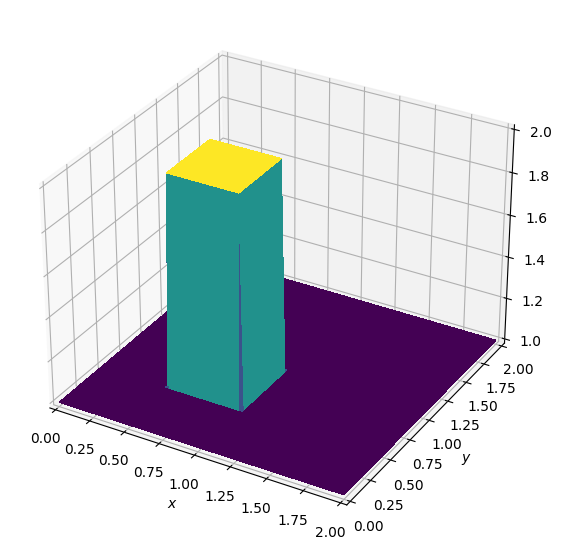

In [8]:
from examples.cfd import plot_field, init_hat
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 81 # grid points in x dim
ny = 81 # grid points in y dim
nt = 100 # Number of time steps
c = 1.
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
print("dx %s, dy %s" % (dx, dy))
sigma = .2
dt = sigma * dx # Time step

# Create field and assign initial conditions
u = np.empty((nx, ny))
init_hat(field=u, dx=dx, dy=dy, value=2.)

# Plot initial condition
plot_field(u)

In [9]:
# Implement your schme here:


OK, now lets implement the same scheme in Devito. But first, lets learn a bit more about the symbolic DSL.

The functions we created above all act as `sympy.Function` objects, which means that we can form symbolic derivative expressions from them. Devito provides a set of shorthand expressions (implemented as Python properties) that allow us to generate finite differences in symbolic form. For example, the property `f.dx` denotes $\frac{\partial}{\partial x} f(x, y)$ - only that Devito has already discretised it with a finite difference expression. There are also a set of shorthand expressions for left (backward) and right (forward) derivatives:

| Derivative | Shorthand | Discretised | Stencil |
| ---------- |:---------:|:-----------:|:-------:|
| $\frac{\partial}{\partial x}f(x, y)$ (right) | `f.dxr` | $\frac{f(x+h_x,y)}{h_x} - \frac{f(x,y)}{h_x}$ | <img src="figures/stencil_forward.png" style="width: 180px;"/> |
| $\frac{\partial}{\partial x}f(x, y)$ (left) | `f.dxl` | $\frac{f(x,y)}{h_x} - \frac{f(x-h_x,y)}{h_x}$ | <img src="figures/stencil_backward.png" style="width: 180px;"/> |

A similar set of expressions exist for each spatial dimension defined on our grid, for example `f.dy` and `f.dyl`. 

In [10]:
f.dxr # Forward difference/right derivative

Derivative(f(x, y), x)

In [11]:
f.dxl # Backward difference/left derivative

Derivative(f(x, y), x)

And to see the actual stencils they represent, we enduce the `evaluate` method:

In [12]:
f.dxr.evaluate

-f(x, y)/h_x + f(x + h_x, y)/h_x

In [13]:
f.dxl.evaluate

f(x, y)/h_x - f(x - h_x, y)/h_x

One can also take derivatives in time of `TimeFunction` objects. For example, to take the first derivative in time of `g` you can simply write:

In [14]:
g.dt

Derivative(g(t, x, y), t)

We may also want to take a look at the stencil Devito will generate based on the chosen discretisation:

In [15]:
g.dt.evaluate

-g(t, x, y)/dt + g(t + dt, x, y)/dt

There also exist convenient shortcuts to express the forward and backward stencil points, `g(t+dt, x, y)` and `g(t-dt, x, y)`.

In [16]:
g.forward

g(t + dt, x, y)

In [17]:
g.backward

g(t - dt, x, y)

And of course, there's nothing to stop us taking derivatives on these objects:

In [18]:
g.forward.dt.evaluate

-g(t + dt, x, y)/dt + g(t + 2*dt, x, y)/dt

In [19]:
g.forward.dy.evaluate

-g(t + dt, x, y)/h_y + g(t + dt, x, y + h_y)/h_y

Lets now implement the linear convection operator from above in Devito:

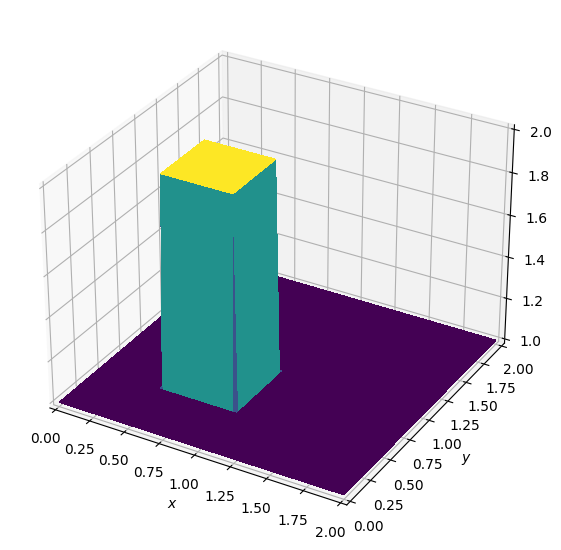

In [20]:
from examples.cfd import init_smooth, plot_field

nt = 100  # Number of timesteps
dt = 0.2 * 2. / 80  # Timestep size (sigma=0.2)
c = 1  # Value for c

# Then we create a grid and our function
grid = Grid(shape=(81, 81), extent=(2., 2.))
u = TimeFunction(name='u', grid=grid)

# We can now set the initial condition and plot it
init_hat(field=u.data[0,:], dx=grid.spacing[0], dy=grid.spacing[1], value=2.)

plot_field(u.data[0])

Next, we wish to discretise our governing equation so that a functional `Operator` can be created from it. We begin by simply writing out the equation as a symbolic expression, while using shorthand expressions for the derivatives provided by the `Function` object. This will create a symbolic object of the dicretised equation.

Using the Devito shorthand notation, we can express the governing equations as:

In [21]:
eq = Eq(u.dt + c * u.dxl + c * u.dyl)
eq

Eq(Derivative(u(t, x, y), x) + Derivative(u(t, x, y), y) + Derivative(u(t, x, y), t), 0)

We now need to rearrange our equation so that the term $u(t+dt, x, y)$ is on the left-hand side, since it represents the next point in time for our state variable $u$. Devito provides a utility called `solve`, built on top of SymPy's `solve`, to rearrange our equation so that it represents a valid state update for $u$. Here, we use `solve` to create a valid stencil for our update to `u(t+dt, x, y)`:

In [22]:
stencil = solve(eq, u.forward)
update = Eq(u.forward, stencil)
update

Eq(u(t + dt, x, y), dt*(-Derivative(u(t, x, y), x) - Derivative(u(t, x, y), y) + u(t, x, y)/dt))

We can check our `update` scheme is the same as our pen and paper scheme by `evaluate`ing it:

In [23]:
update.evaluate

Eq(u(t + dt, x, y), dt*(-(u(t, x, y)/h_x - u(t, x - h_x, y)/h_x) - (u(t, x, y)/h_y - u(t, x, y - h_y)/h_y) + u(t, x, y)/dt))

The right-hand side of the 'update' equation should be a stencil of the shape
<img src="figures/stencil_convection.png" style="width: 160px;"/>

Next we define our boundary conditions:

In [24]:
x, y = grid.dimensions
t = grid.stepping_dim
bc_left = Eq(u[t + 1, 0, y], 1.)
bc_right = Eq(u[t + 1, nx-1, y], 1.)
bc_top = Eq(u[t + 1, x, ny-1], 1.)
bc_bottom = Eq(u[t + 1, x, 0], 1.)

Once we have created this 'update' expression and the appropriate boundary conditions, we can create a Devito `Operator`. This `Operator` will basically behave like a Python function that we can call to apply the created stencil over our associated data, as long as we provide all necessary unknowns. In this case we need to provide the number of timesteps to compute via the keyword `time` and the timestep size via `dt` (both have been defined above):

Operator `Kernel` ran in 0.01 s
/data/devito/examples/cfd/tools.py:38: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


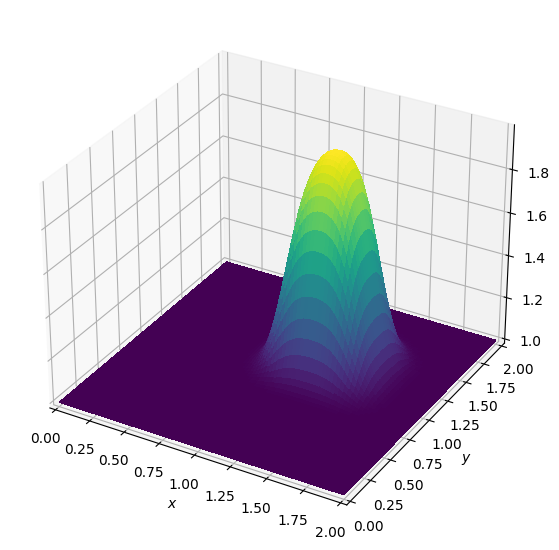

In [25]:
op = Operator([update, bc_left, bc_right, bc_top, bc_bottom])
op(time=nt+1, dt=dt)

plot_field(u.data[0])

Note that the real power of Devito is hidden within `Operator`, it will automatically generate and compile the optimized C code. We can look at this code (noting that this is not a requirement of executing it) via:

In [26]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#define START_TIMER(S) struct timeval start_ ## S , end_ ## S ; gettimeofday(&start_ ## S , NULL);
#define STOP_TIMER(S,T) gettimeofday(&end_ ## S, NULL); T->S += (double)(end_ ## S .tv_sec-start_ ## S.tv_sec)+(double)(end_ ## S .tv_usec-start_ ## S .tv_usec)/1000000;

#include "stdlib.h"
#include "math.h"
#include "sys/time.h"
#include "xmmintrin.h"
#include "pmmintrin.h"

struct dataobj
{
  void *restrict data;
  int * size;
  int * npsize;
  int * dsize;
  int * hsize;
  int * hofs;
  int * oofs;
} ;

struct profiler
{
  double section0;
  double section1;
  double section2;
} ;


int Kernel(const float dt, const float h_x, const float h_y, struct dataobj *restrict u_vec, const int time_M, const int time_m, const int x_M, const int x_m, const int y_M, const int y_m, struct profiler * timers)
{
  float (*restrict u)[u_vec->size[1]][u_vec->size[2]] __attribute__ ((aligned (64))) = (float (*)[u_vec->size[1]][u_vec->size[2]]) u_vec->data;

  /* Flush deno

#### Second derivatives and high-order stencils

In the above example only a combination of first derivatives was present in the governing equation. However, second (or higher) order derivatives are often present in scientific problems of interest, notably any PDE modeling diffusion. To generate second order derivatives we must give the `devito.Function` object another piece of information: the desired discretisation of the stencil(s).

First, lets define a simple second derivative in `x`, for which we need to give $u$ a `space_order` of (at least) `2`. The shorthand for this second derivative is `u.dx2`.

In [27]:
u = TimeFunction(name='u', grid=grid, space_order=2)
u.dx2

Derivative(u(t, x, y), (x, 2))

In [28]:
u.dx2.evaluate

-2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2

We can increase the discretisation arbitrarily if we wish to specify higher order FD stencils:

In [29]:
u = TimeFunction(name='u', grid=grid, space_order=4)
u.dx2

Derivative(u(t, x, y), (x, 2))

In [30]:
u.dx2.evaluate

-2.5*u(t, x, y)/h_x**2 - 0.0833333333*u(t, x - 2*h_x, y)/h_x**2 + 1.33333333*u(t, x - h_x, y)/h_x**2 + 1.33333333*u(t, x + h_x, y)/h_x**2 - 0.0833333333*u(t, x + 2*h_x, y)/h_x**2

To implement the diffusion or wave equations, we must take the Laplacian $\nabla^2 u$, which is the sum of the second derivatives in all spatial dimensions. For this, Devito also provides a shorthand expression, which means we do not have to hard-code the problem dimension (2D or 3D) in the code. To change the problem dimension we can create another `Grid` object and use this to re-define our `Function`'s:

In [31]:
grid_3d = Grid(shape=(5, 6, 7), extent=(1., 1., 1.))

u = TimeFunction(name='u', grid=grid_3d, space_order=2)
u

u(t, x, y, z)

We can re-define our function `u` with a different `space_order` argument to change the discretisation order of the stencil expression created. For example, we can derive an expression of the 12th-order Laplacian $\nabla^2 u$:

In [32]:
u = TimeFunction(name='u', grid=grid_3d, space_order=12)
u.laplace

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

The same expression could also have been generated explicitly via:

In [33]:
u.dx2 + u.dy2 + u.dz2

Derivative(u(t, x, y, z), (x, 2)) + Derivative(u(t, x, y, z), (y, 2)) + Derivative(u(t, x, y, z), (z, 2))

#### Derivatives of composite expressions

Derivatives of any arbitrary expression can easily be generated:

In [34]:
u = TimeFunction(name='u', grid=grid, space_order=2)
v = TimeFunction(name='v', grid=grid, space_order=2, time_order=2)

In [35]:
(v.dt2 + u.laplace).dx2

Derivative(Derivative(u(t, x, y), (x, 2)) + Derivative(u(t, x, y), (y, 2)) + Derivative(v(t, x, y), (t, 2)), (x, 2))

Which can, depending on the chosen discretisation, lead to fairly complex stencils:

In [36]:
(v.dt2 + u.laplace).dx2.evaluate

-2.0*(-2.0*v(t, x, y)/dt**2 + v(t - dt, x, y)/dt**2 + v(t + dt, x, y)/dt**2 - 2.0*u(t, x, y)/h_x**2 + u(t, x - h_x, y)/h_x**2 + u(t, x + h_x, y)/h_x**2 - 2.0*u(t, x, y)/h_y**2 + u(t, x, y - h_y)/h_y**2 + u(t, x, y + h_y)/h_y**2)/h_x**2 + (-2.0*v(t, x - h_x, y)/dt**2 + v(t - dt, x - h_x, y)/dt**2 + v(t + dt, x - h_x, y)/dt**2 + u(t, x, y)/h_x**2 + u(t, x - 2*h_x, y)/h_x**2 - 2.0*u(t, x - h_x, y)/h_x**2 - 2.0*u(t, x - h_x, y)/h_y**2 + u(t, x - h_x, y - h_y)/h_y**2 + u(t, x - h_x, y + h_y)/h_y**2)/h_x**2 + (-2.0*v(t, x + h_x, y)/dt**2 + v(t - dt, x + h_x, y)/dt**2 + v(t + dt, x + h_x, y)/dt**2 + u(t, x, y)/h_x**2 - 2.0*u(t, x + h_x, y)/h_x**2 + u(t, x + 2*h_x, y)/h_x**2 - 2.0*u(t, x + h_x, y)/h_y**2 + u(t, x + h_x, y - h_y)/h_y**2 + u(t, x + h_x, y + h_y)/h_y**2)/h_x**2

In the linear convection example, the complexity of a pure Python vs Devito code wasn't much different, but when you start implementing stencils such as the one above you can see that Devito will quickly become much more convenient!

**IMPORTANT**: Devito should not be thought of as a black box. Every aspect of the DSL has a well defined meaning (as we saw with the definition of derivatives etc. above). Although due to time-constraints there are some aspects of the DSL we're going to have to 'gloss' over, these are also rigorously (and clearly) defined and hence would not be difficult to explain if we had the time.